# Dataset ARPAV
Registrazione delle misure recuperate dal database ARPA Veneto.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) del dataset con SCIA.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|series_id|date|value|merged|variable|
|---------|----|-----|------|--------|
|utf8()|date()|double()|bool()|utf8()|
| fkey    |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [1]:
dataset_id <- "ARPAV"
state <- "Veneto"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/load_daily.R"))
source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == state)


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [3]:
daily_dataset <- load_daily_data.arpav() |> prepare_daily_data(first_date, last_date)
checkpoint_database(daily_dataset$database, dataset_id, "raw")
write_extra_metadata(daily_dataset$extra_meta, dataset_id, provisional = FALSE)
rm(daily_dataset)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1721483,92.0,3230008,172.6,NA,2500170,133.6
Vcells,5990475,45.8,44680635,340.9,16384,55636669,424.5


## Quality check
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

In [4]:
raw_database <- open_checkpoint(dataset_id, "raw")
qc_database <- qc1(raw_database, stop_on_error = TRUE)

checkpoint_database(qc_database, dataset_id, "qc1")
rm(raw_database)
rm(qc_database)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1912499,102.2,3230008,172.6,NA,3230008,172.6
Vcells,6334403,48.4,61999469,473.1,16384,77499003,591.3


## Overview disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

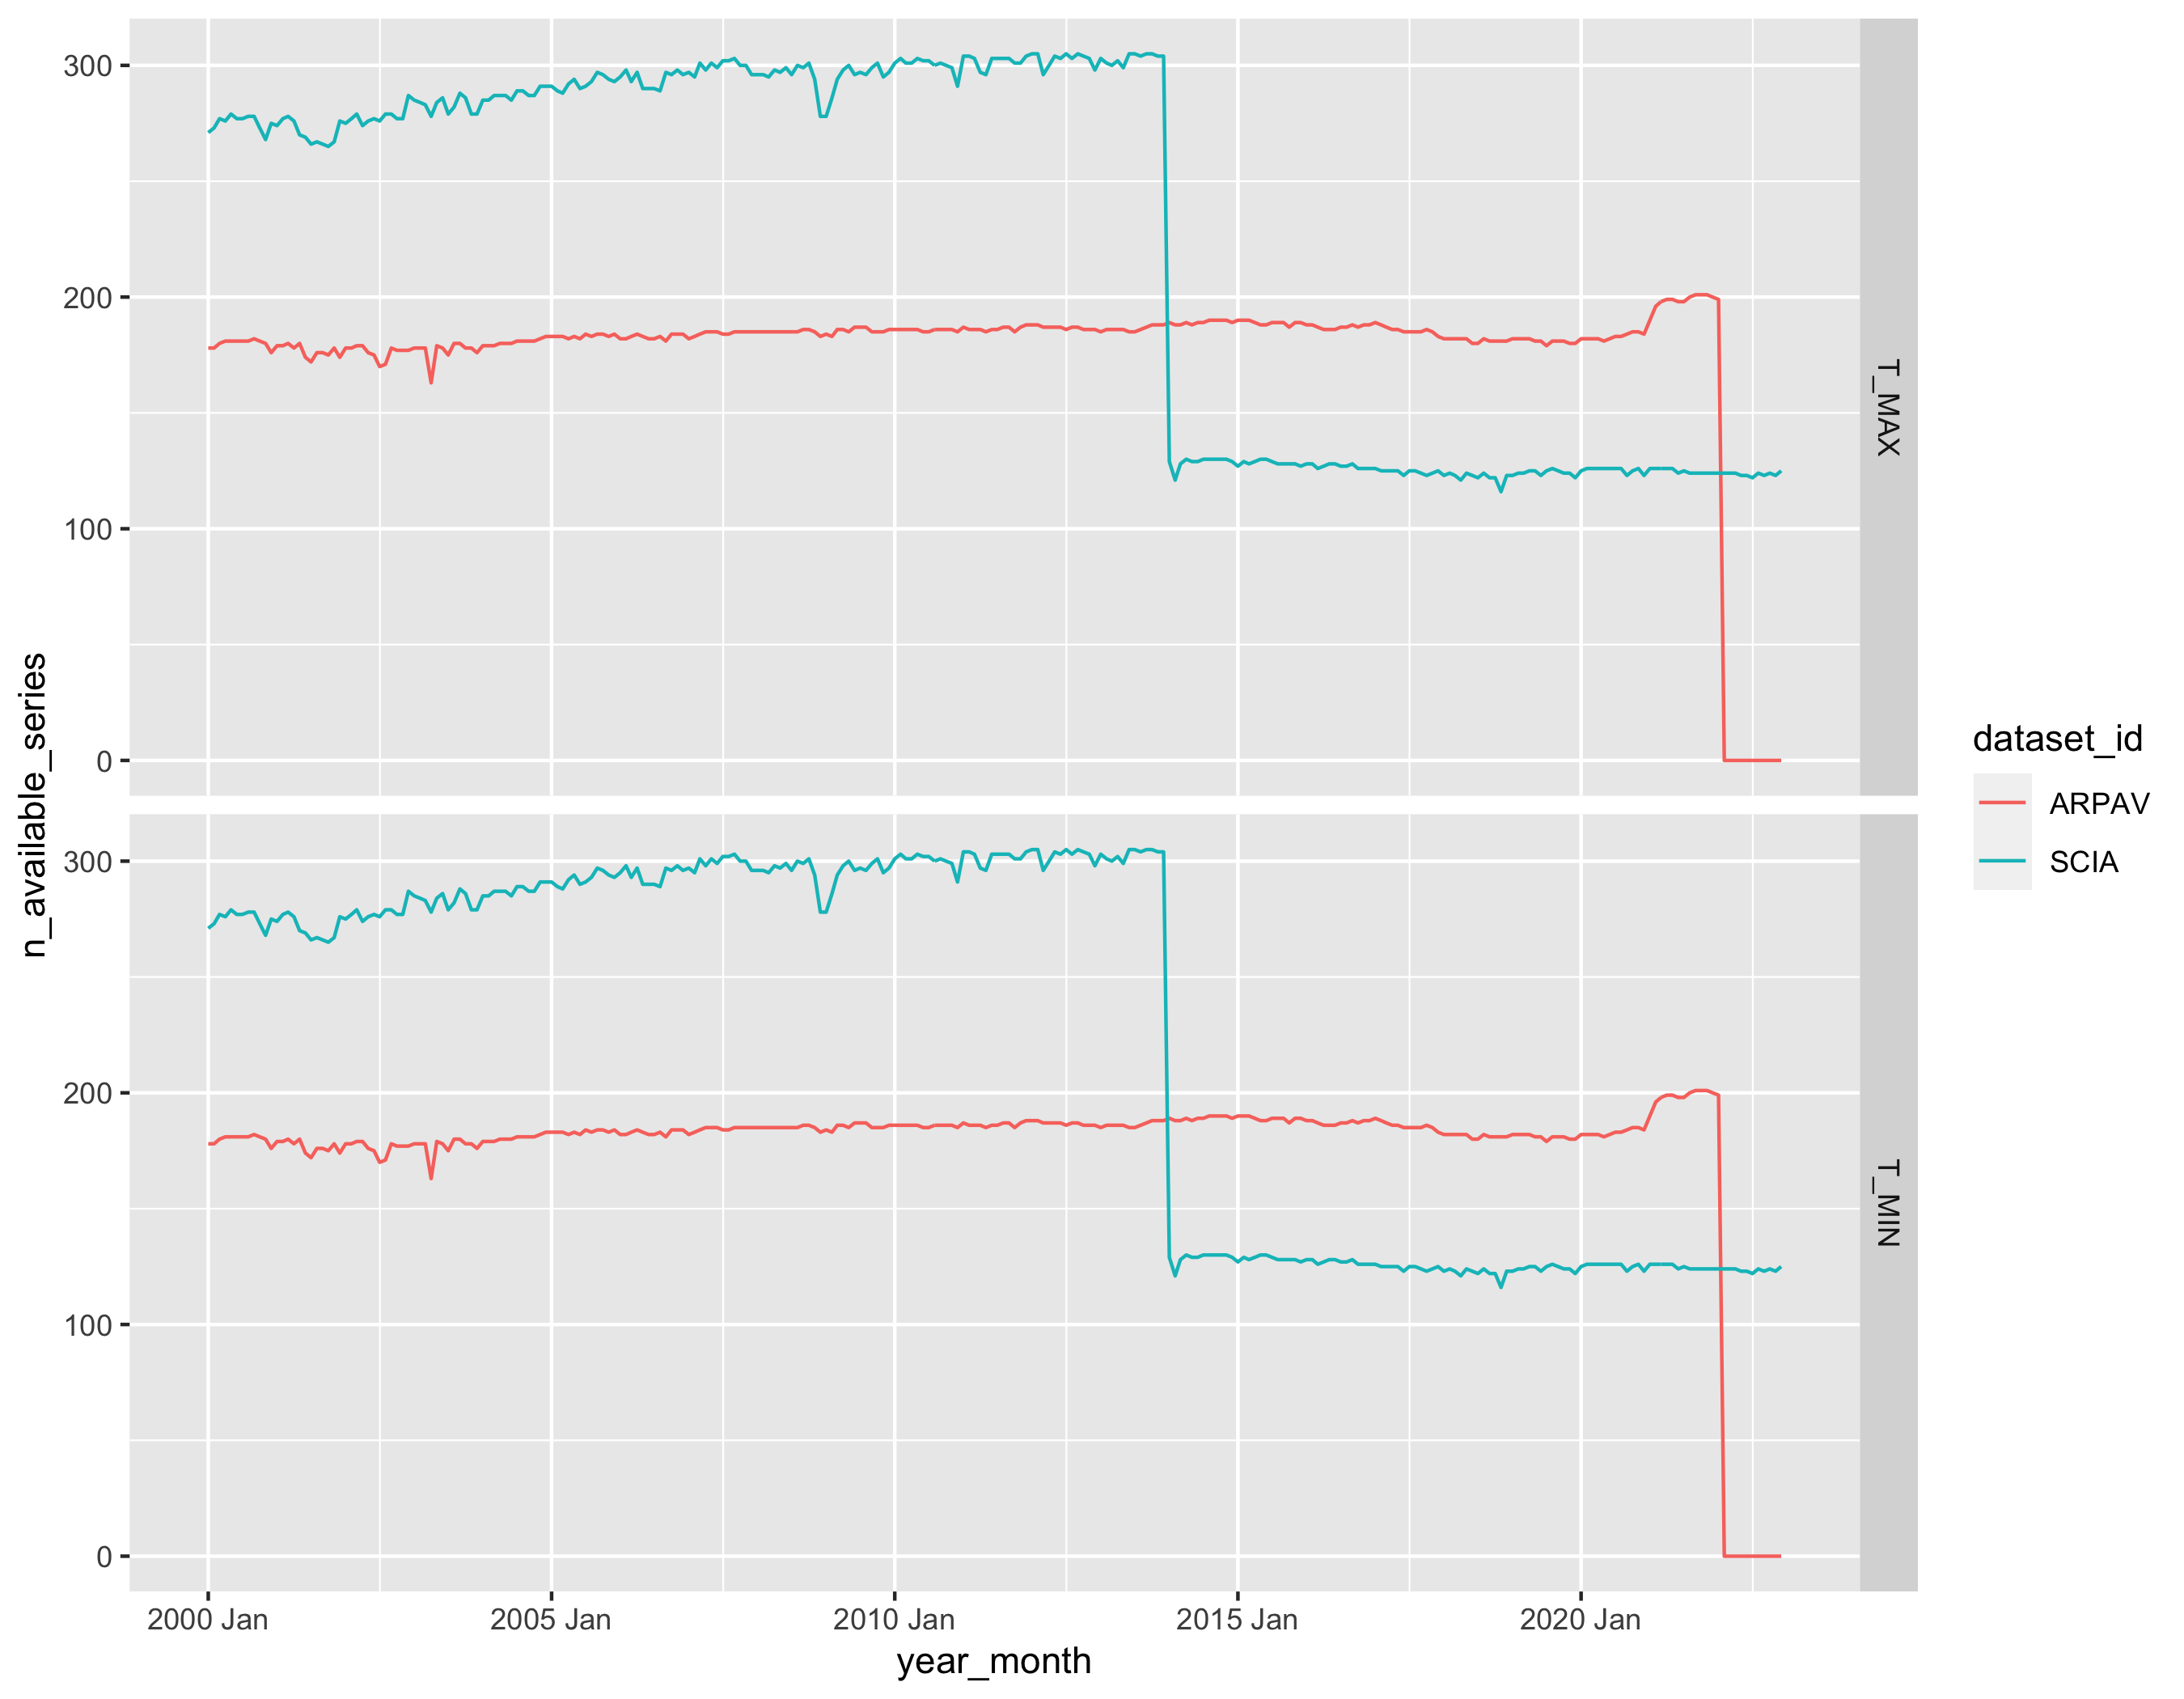

In [5]:
qc_database <- open_checkpoint(dataset_id, "qc1")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database,
    against = "SCIA",
    region = state_boundaries,
    chkp_id = "qc1",
    start_date = first_date,
    end_date = last_date
)
p


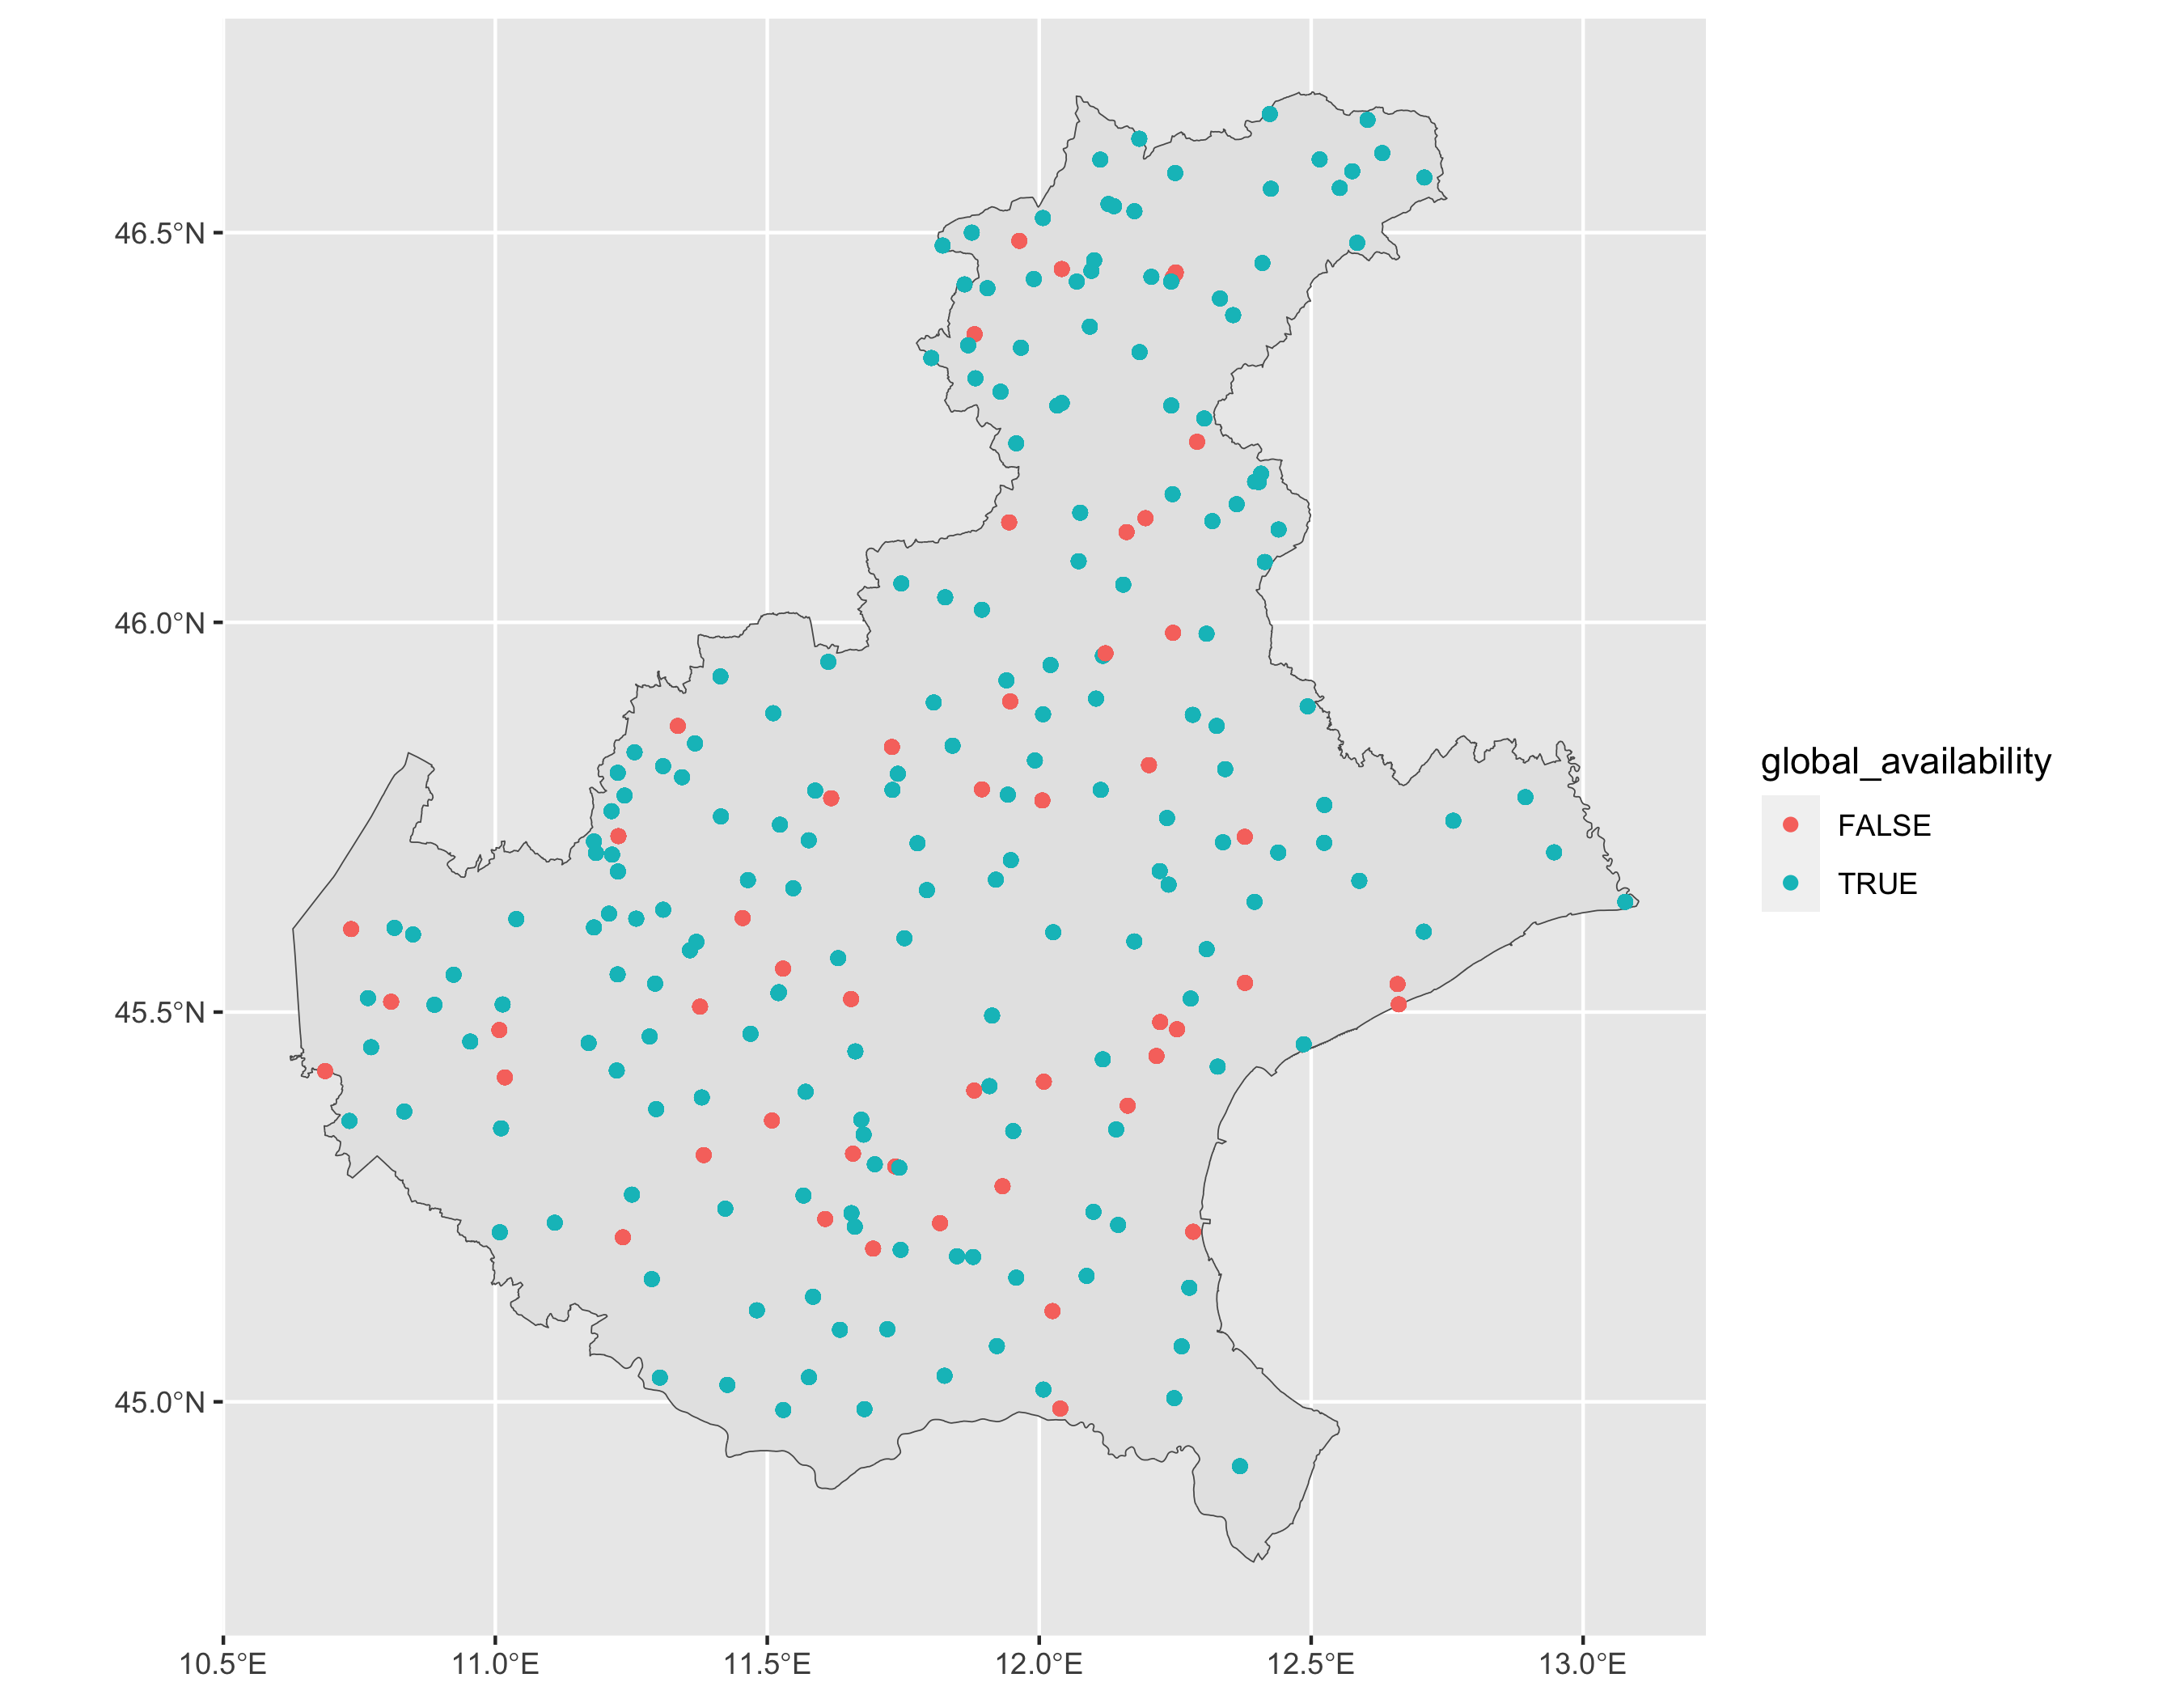

In [6]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail |> filter(dataset_id == !!dataset_id), qc_database$meta, state_boundaries)
p


In [7]:
rm(qc_database)
rm(ymonthly_avail)
rm(climats)
rm(p)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2178811,116.4,5057975,270.2,NA,5057975,270.2
Vcells,4596794,35.1,227043969,1732.3,16384,283804961,2165.3


## Merging
Gap-filling con altri dataset

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

In [3]:
qc_arpav <- open_checkpoint(dataset_id, "qc1")
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries)
analysis_results <- perform_analysis(
    qc_arpav,
    qc_scia,
    dist_km = 10,
    first_date,
    last_date,
    str_to_lower(state),
)

rm(qc_arpav)
rm(qc_scia)
gc()


Data prepared. Launching analysis...

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1986575,106.1,6265000,334.6,NA,7831250,418.3
Vcells,13063236,99.7,618728468,4720.6,16384,773370760,5900.4


In [4]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station, "unusable" = tag_unusable))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n > 4L | n < 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,612
FALSE,TRUE,1608
TRUE,FALSE,641
TRUE,TRUE,27


station_id.x,n
<chr>,<int>
6686b31c6bcebee8e9494e14ffc68fb0,6
7f87b887e813f38be09a56b94d803e6b,6
8f13a8f8ac966a3dc3bd9d40a01a985b,6
bf571cea11657b13df57c8c3ba08cafc,8
f076e731cf17a75546be73919cee1fa5,6


station_id.y,n
<chr>,<int>
051e5e042eae502992092f6661ba3e20,4
1c5234a0a97de1267a9150f72396e94f,4
3b5bf29ad5fbdec15aae41da1879b22b,4
3ef283db1965b106a9911d500cab4779,4
43b037d907c6f24798bf43ca95cb7a4c,4
448dedd02305d1d62a4a92eff9cb5362,4
467e3319e7aaea4af74785d303a920a1,6
540ed5edd177def86eb43a4979854879,4
54a695cb1b414bd67a301b45ad7c95f9,6


In [5]:
combination_results <- build_combined_database(analysis_results)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")

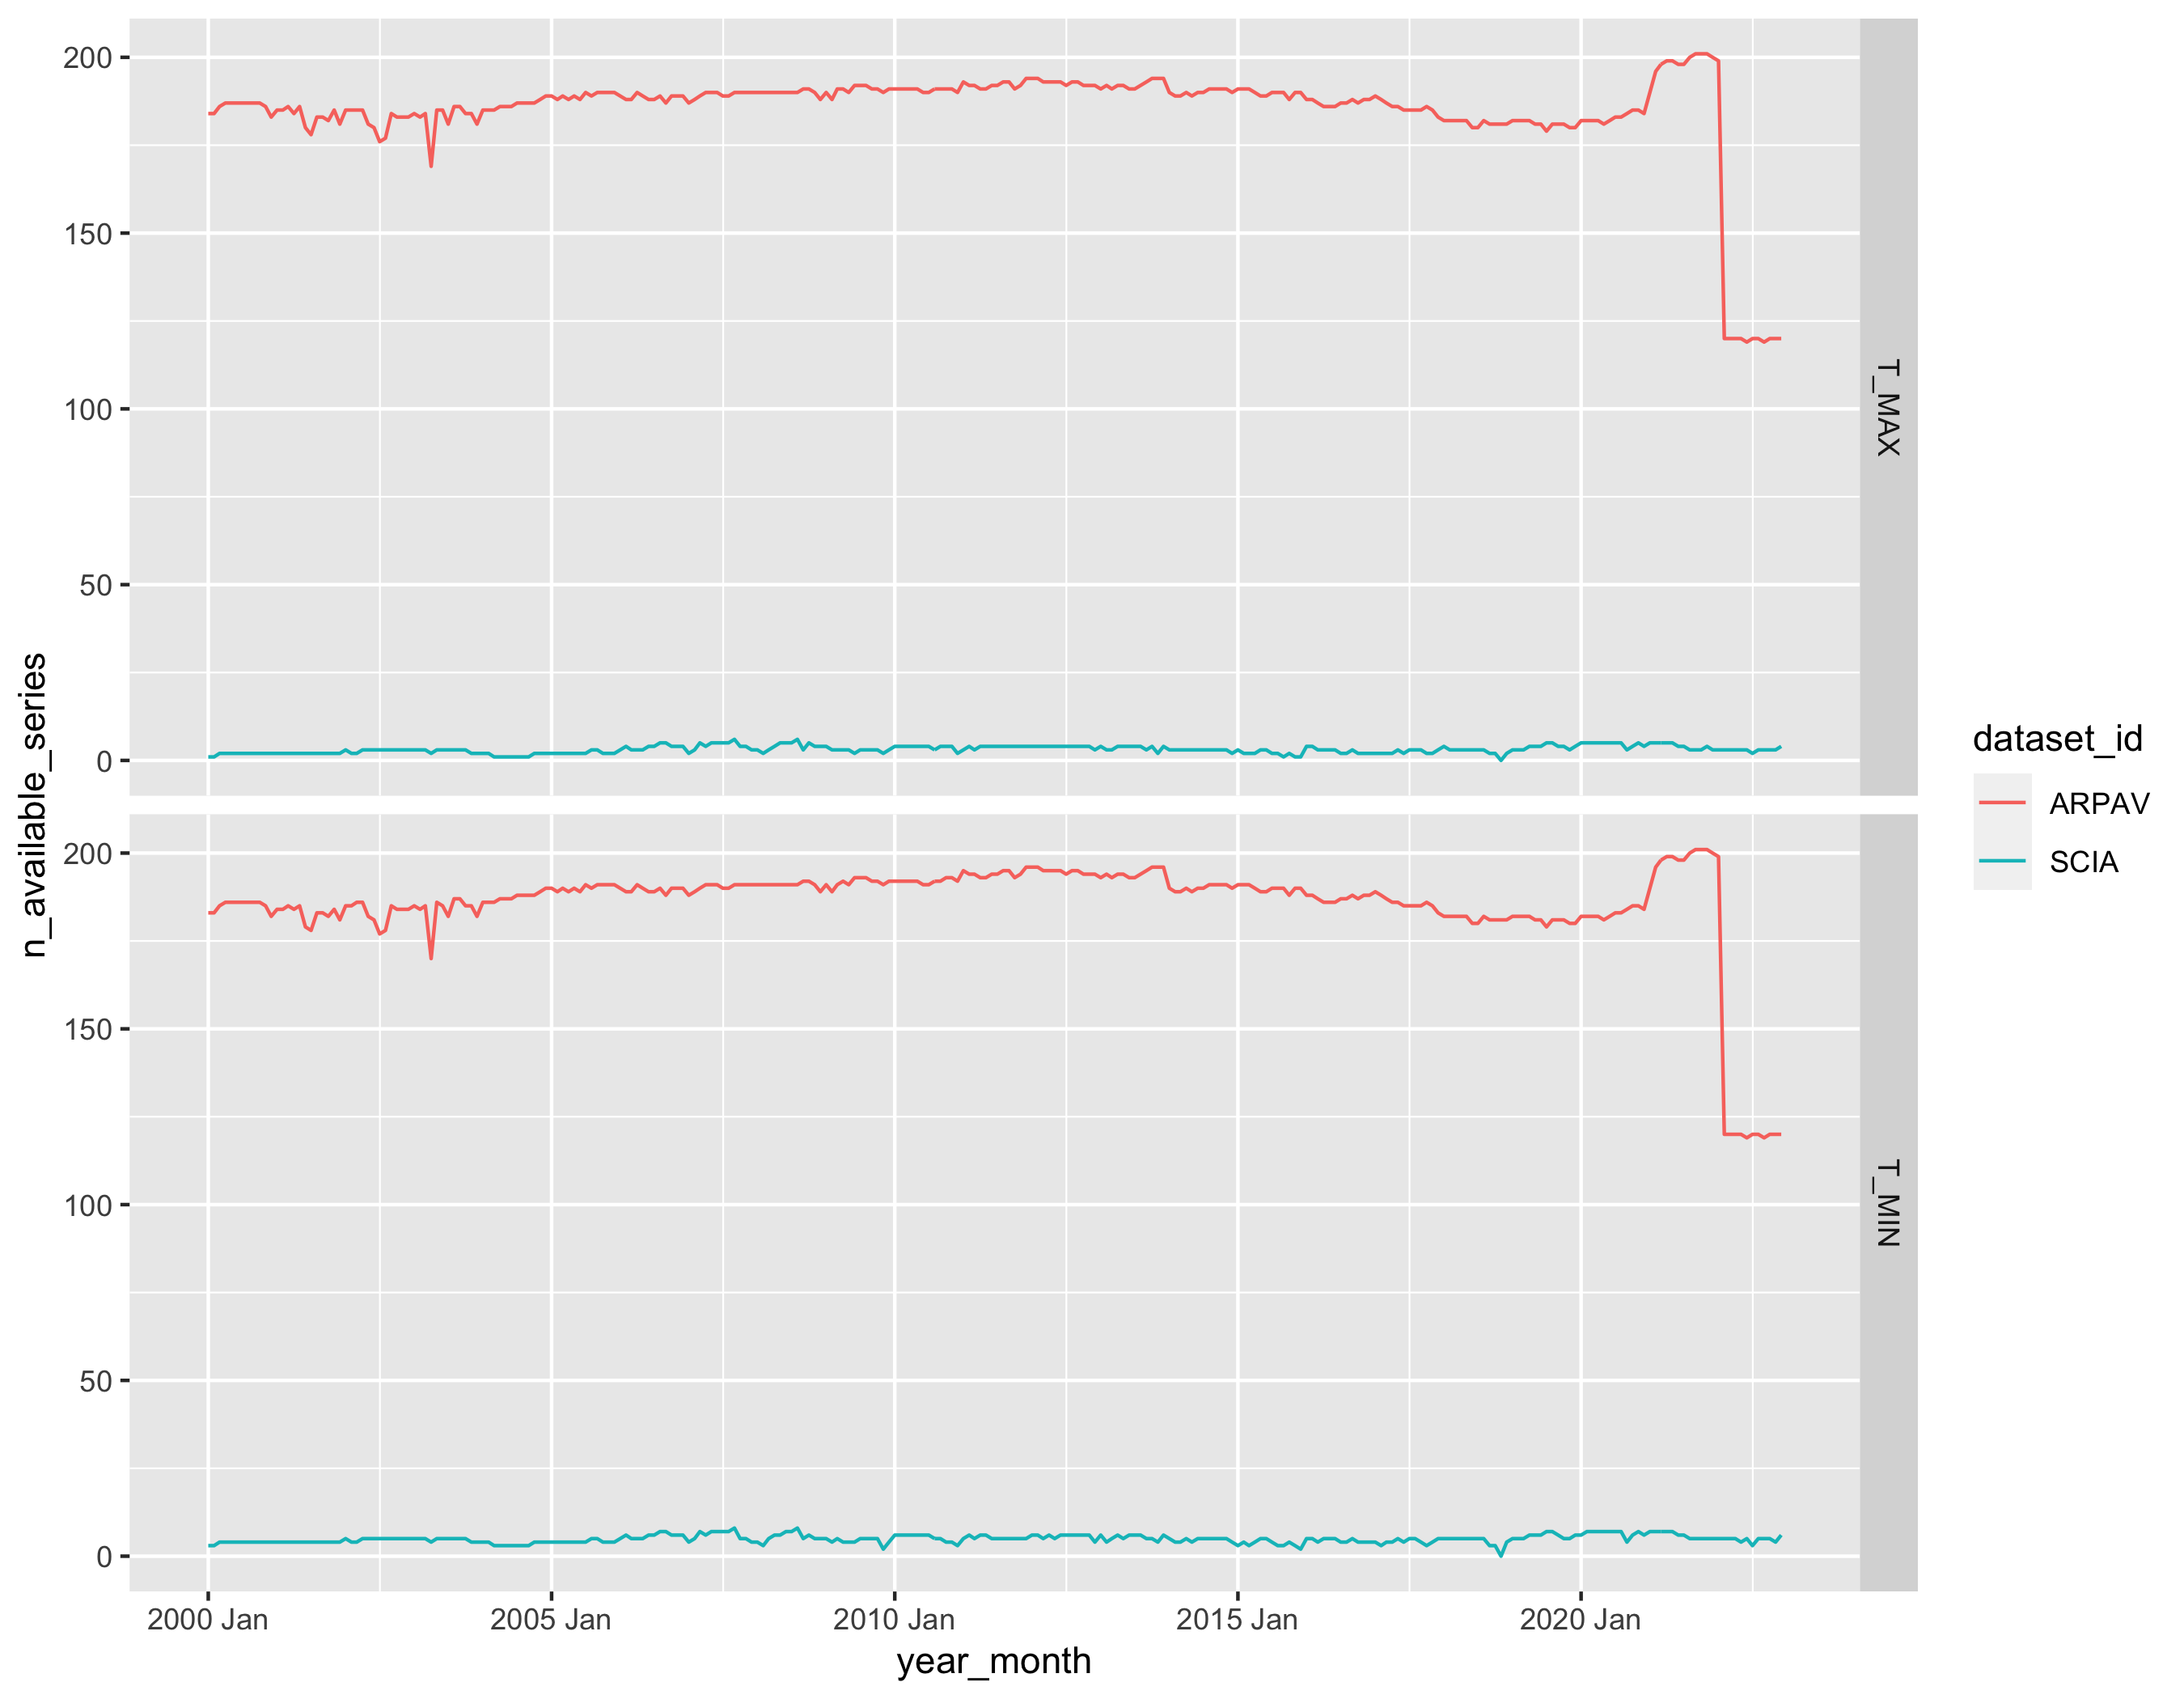

In [6]:
combined_database <- open_checkpoint(dataset_id, "merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p

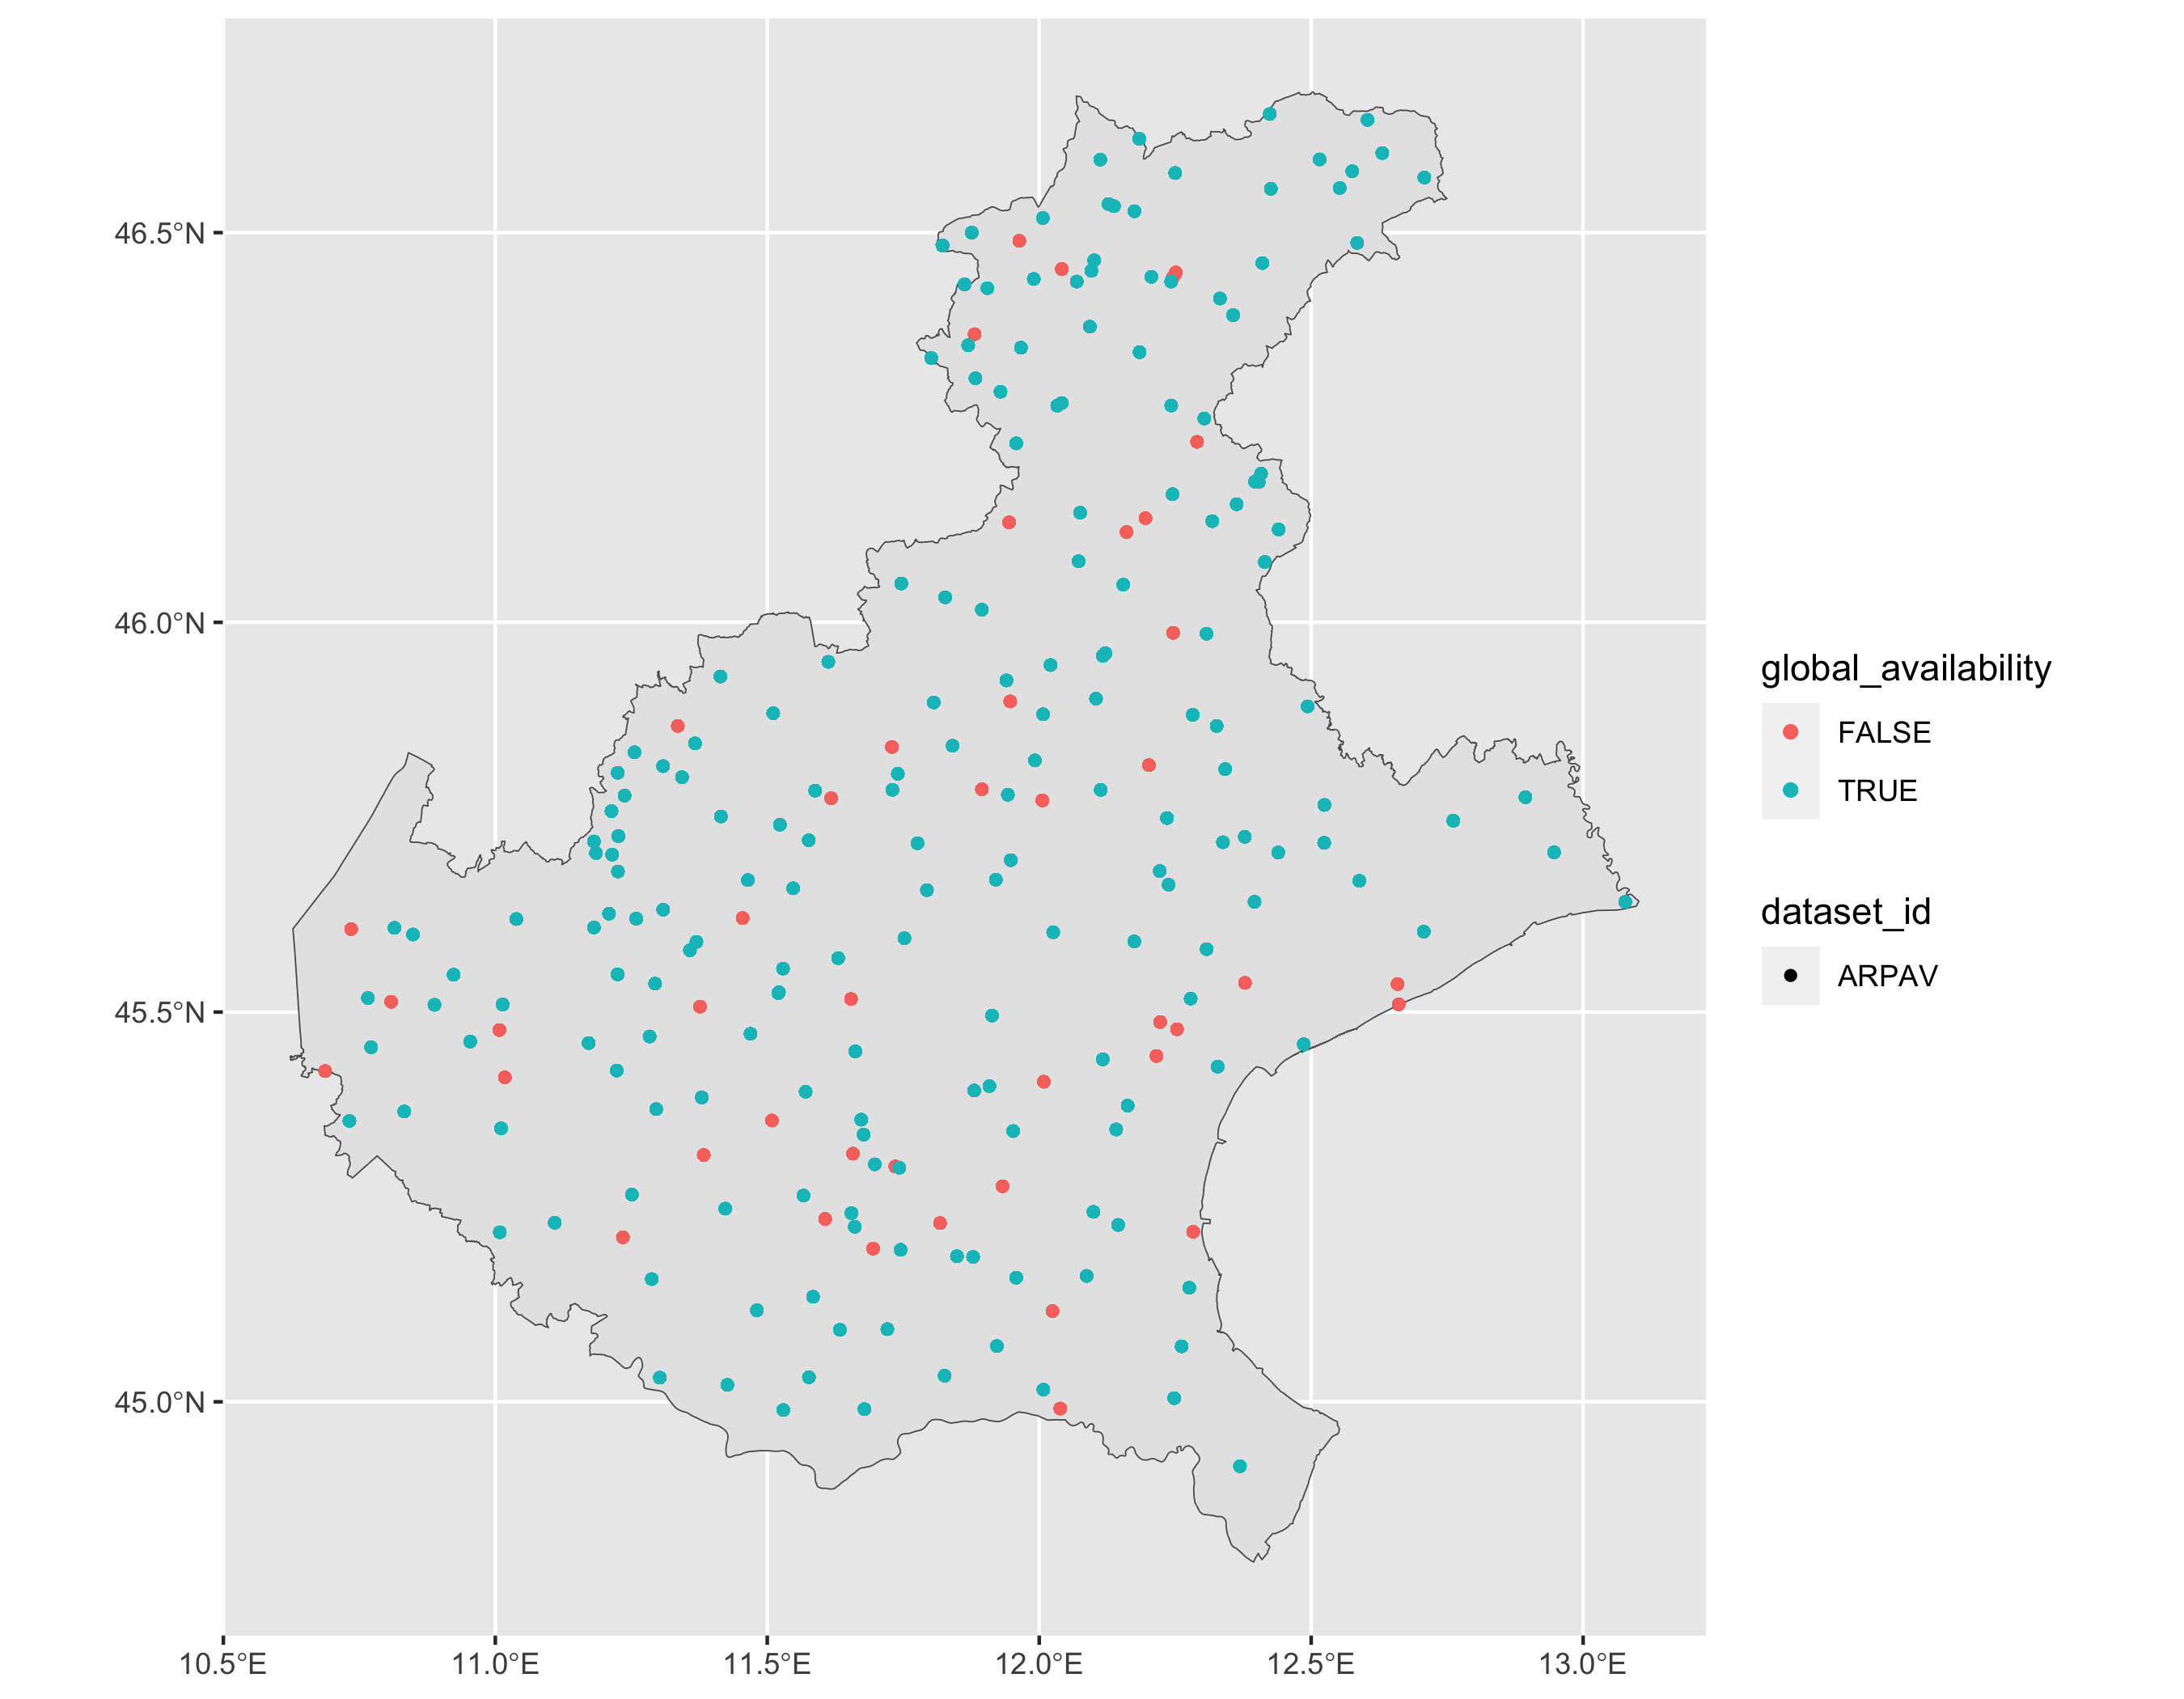

In [7]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail |> filter(dataset_id == !!dataset_id), combined_database$meta, state_boundaries)
p

In [8]:
combined_database$data |> distinct(station_id, variable) |> compute() |> nrow()

[1] 498

In [ ]:
source("src/pairing/displaying.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint("ARPAV", "qc1") |>
    launch_leaflet()